In [1]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from adad.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent.parent
print(PATH_ROOT)

c:\Users\lukex\workspace\applicabilityDomain


## Objective

Create Predictiveness Curves (PC) plots per dataset per model;

## Predictiveness Curves (PC) Plot

- First, sort samples based on the Applicability Domain measures;
- Dividing the samples into n equally sized bins;
- Applying 2nd degree polynomial interpolation;
- The worst case is a horizontal line, which indicates the AD cannot distinguish 
reliable and unreliable predictions.
- Y axis: Prediction error rate (%)
- X axis: Compounds Percentile (%) 

In [3]:
# Constants
CLASSIFIERS = ['KNeighborsClassifier', 'NNClassifier', 'RandomForestClassifier', 'SVC']
CLF_alias = ['KNN', 'NN', 'RF', 'SVM']
AD = ['DAIndexDelta', 
      'DAIndexGamma', 
      'DAIndexKappa', 
      'PCABoundingBox', 
      'ProbabilityClassifier', 
      'Magnet',
      'SklearnFeatureSqueezing', 
      'SklearnRegionBasedClassifier',
]
AD_alias = ['DM-δ',
            'DM-γ',
            'DM-κ',
            'BB',
            'Prob.',
            'Magnet',
            'FS',
            'RC'
]
AL = ['Magnet', 'FS', 'RC']
DATASETS = ['Ames', 'BBBP', 'Cancer', 'CYP1A2', 'hERG', 'HIV', 'Liver']
COLOURS = ['#882E72', '#1965B0', '#7BAFDE', '#4EB265', '#CAE0AB', '#F7F056', '#EE8026', '#DC050C']

In [4]:
def get_data_path(model, ad, dataset, suffix):
    """Return a full path of the ROC results;"""
    path_file = os.path.join(PATH_ROOT, 'results', f'{model}_{ad}', f'{dataset}_{suffix}.csv')
    return path_file

# Test function
path_test = get_data_path(CLASSIFIERS[0], AD[0], DATASETS[0], suffix='PredictivenessCurves')
print(path_test)
df_test = pd.read_csv(path_test)
df_test.head()

c:\Users\lukex\workspace\applicabilityDomain\results\KNeighborsClassifier_DAIndexDelta\Ames_PredictivenessCurves.csv


,cv1_percentile,cv1_err_rate,cv2_percentile,cv2_err_rate,cv3_percentile,cv3_err_rate,cv4_percentile,cv4_err_rate,cv5_percentile,cv5_err_rate
0,0.02,0.130435,0.02,0.102564,0.02,0.075949,0.02,0.135135,0.02,0.095238
1,0.04,0.130435,0.04,0.102564,0.04,0.075949,0.04,0.135135,0.04,0.095238
2,0.06,0.130435,0.06,0.102564,0.06,0.075949,0.06,0.135135,0.06,0.095238
3,0.08,0.140000,0.08,0.115385,0.08,0.069307,0.08,0.168421,0.08,0.076923
4,0.10,0.144000,0.10,0.125000,0.10,0.076923,0.10,0.153846,0.10,0.082707


In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV

In [6]:
def get_mean_err_rate(clf, ad, dataset, degree=2, x=np.linspace(0, 1, 30)):
    """Compute mean Error Rate using polynomial interpolation;"""
    err_rates = []

    df = pd.read_csv(get_data_path(clf, ad, dataset, suffix='PredictivenessCurves'))
    for i in range(1, 6):
        percentile_1fold = df[f'cv{i}_percentile'].dropna().to_numpy()
        err_rate_1fold = df[f'cv{i}_err_rate'].dropna().to_numpy()

        model = make_pipeline(PolynomialFeatures(degree), RidgeCV())
        model.fit(percentile_1fold.reshape(-1, 1), err_rate_1fold)
        err_rate = model.predict(x.reshape(-1, 1))

        err_rates.append(err_rate)

    err_rates = np.mean(err_rates, axis=0)
    return err_rates

# Test function
err_rate = get_mean_err_rate(CLASSIFIERS[0], AD[0], DATASETS[0])
print(err_rate)

[0.11999404 0.12449273 0.1289244  0.13328905 0.13758669 0.14181731
 0.14598091 0.15007749 0.15410705 0.1580696  0.16196513 0.16579364
 0.16955513 0.1732496  0.17687706 0.1804375  0.18393092 0.18735732
 0.1907167  0.19400907 0.19723442 0.20039275 0.20348406 0.20650836
 0.20946563 0.21235589 0.21517913 0.21793535 0.22062456 0.22324675]


In [7]:
def get_df_pc(clf, dataset, degree=2):
    """Get a DataFrame that contains all AD method on 1 dataset and 1 classifier;""" 
    x=np.linspace(0, 1, 30)
    _df = pd.DataFrame({ 'X': x * 100 })

    for ad, ad_lbl in zip(AD, AD_alias):
        # print(i, ad, ad_lbl)
        _acc = get_mean_err_rate(clf, ad, dataset, degree=degree,x=x) * 100
        _df = pd.concat((_df, pd.DataFrame({ ad_lbl: _acc })), axis=1)
    return _df

# Test function
df_test = get_df_pc(CLASSIFIERS[0], DATASETS[0])
df_test.head()

,X,DM-δ,DM-γ,DM-κ,BB,Prob.,Magnet,FS,RC
0,0.000000,11.999404,11.217552,11.299304,18.838238,8.565485,17.358879,12.114787,6.332104
1,3.448276,12.449273,11.602720,11.770893,19.000249,8.615642,17.234699,11.891821,6.397055
2,6.896552,12.892440,11.988326,12.236841,19.158682,8.684657,17.126655,11.701477,6.493907
3,10.344828,13.328905,12.374371,12.697150,19.313536,8.772531,17.034745,11.543755,6.622659
4,13.793103,13.758669,12.760855,13.151820,19.464812,8.879264,16.958971,11.418653,6.783312


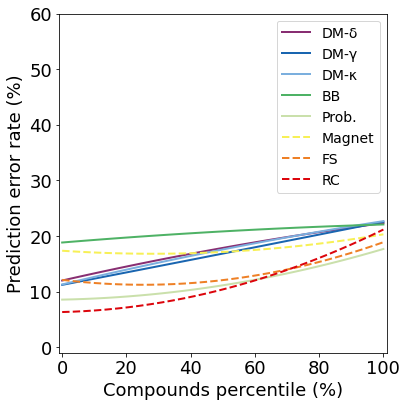

In [8]:
def plot_pc(clf, clf_alias, dataset, path_output, figsize=(6,6), fontsize=18, show_title=False):
    """Plot Predictiveness Curves (PC) plot"""
    plt.rc("figure", autolayout=True, figsize=figsize)
    plt.rcParams["font.size"] = fontsize
    plt.rc('legend', fontsize=14)

    fig, ax = plt.subplots()

    df = get_df_pc(clf, dataset)
    for i, ad in enumerate(df.columns[1:]):
        # Dashed lines for all advx. defenses
        ls = '--' if ad in AL else '-'
        ax.plot(df[df.columns[0]], 
                df[ad], 
                alpha=1, 
                lw=2, 
                color=COLOURS[i], 
                ls=ls, 
                label=ad,
        )

    ax.set(xlim=[-1., 101.], ylim=[-1., 60.])
    ax.legend()
    ax.set_xlabel('Compounds percentile (%)')
    ax.set_ylabel('Prediction error rate (%)')
    if show_title:
        ax.set_title(f'{dataset} on {clf_alias} - Predictiveness Curves')
    plt.tight_layout()
    plt.savefig(path_output, dpi=300)


# Test function
path_test = os.path.join(PATH_ROOT, 'plot_results', 'ames_knn_pc.pdf')
plot_pc(CLASSIFIERS[0], CLF_alias[0], DATASETS[0], path_test)
os.remove(path_test)

C:\Users\lukex\AppData\Local\Temp/ipykernel_14860/1666714139.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


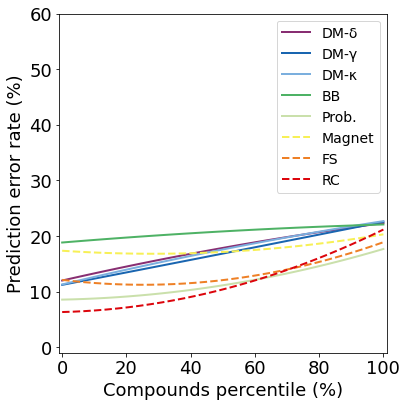

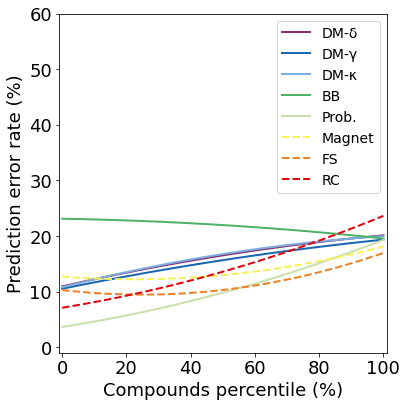

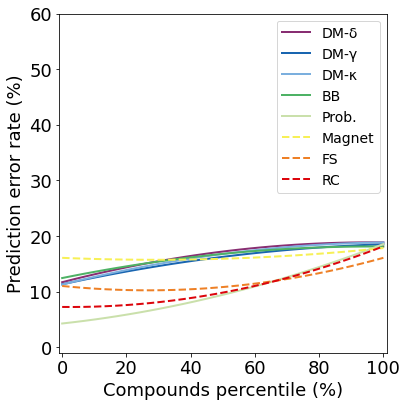

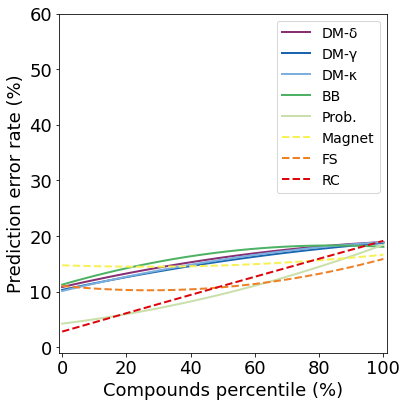

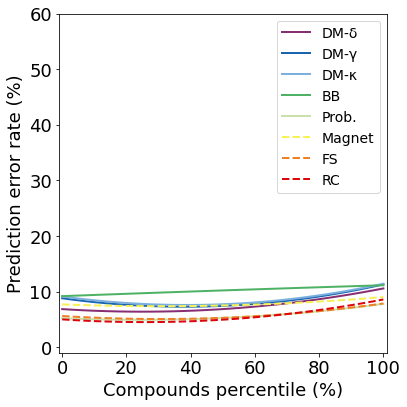

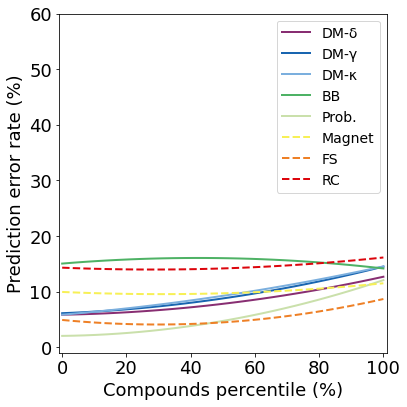

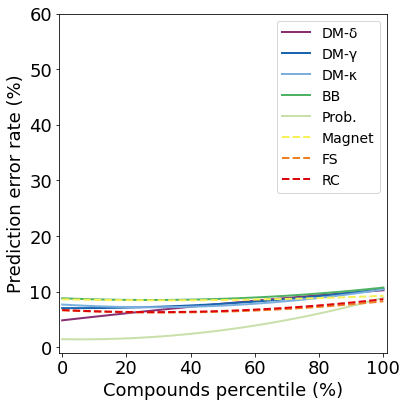

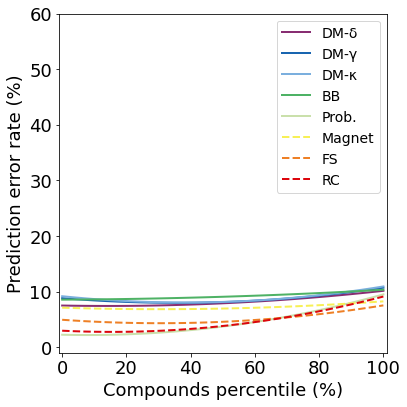

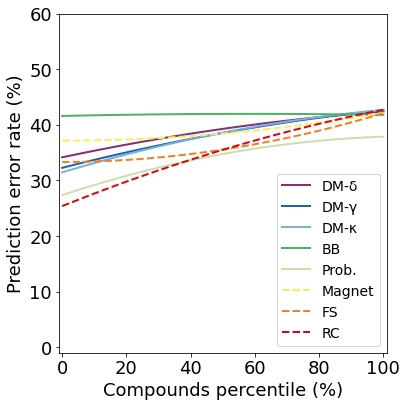

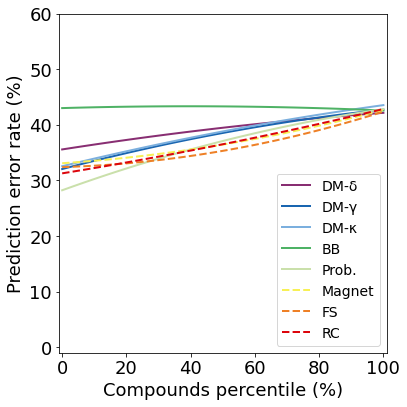

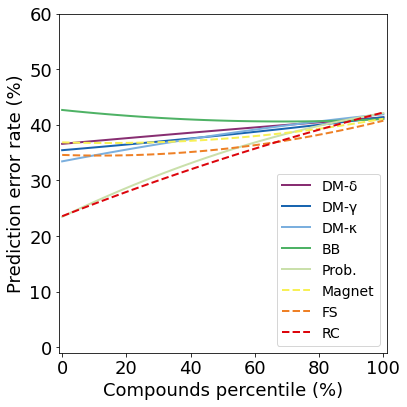

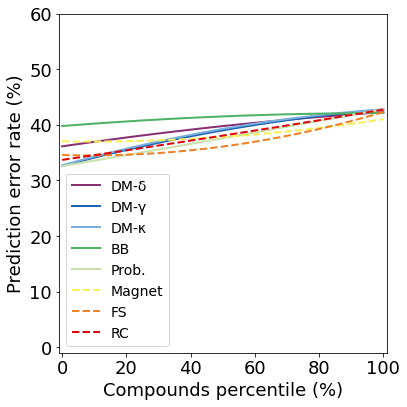

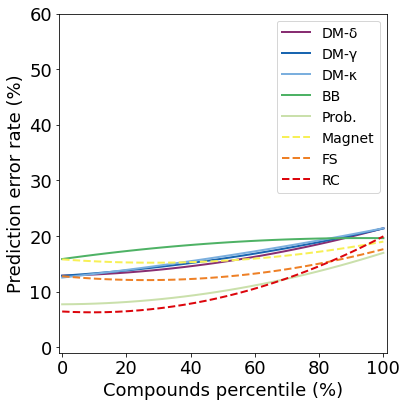

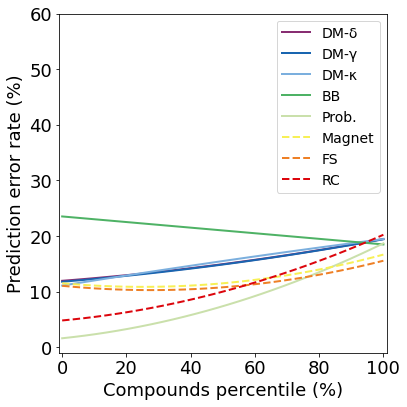

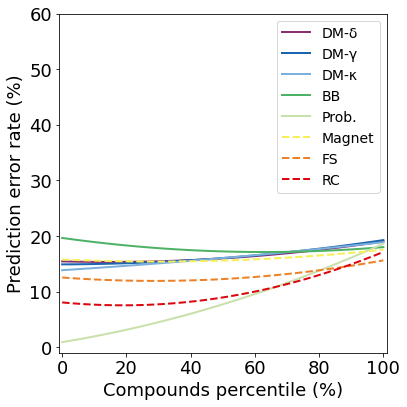

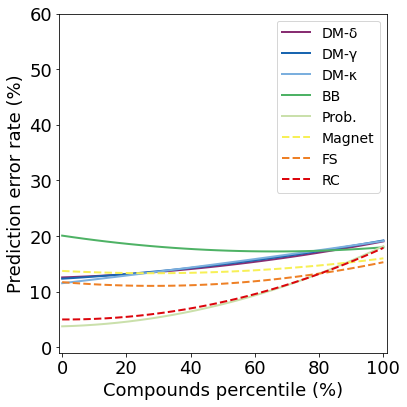

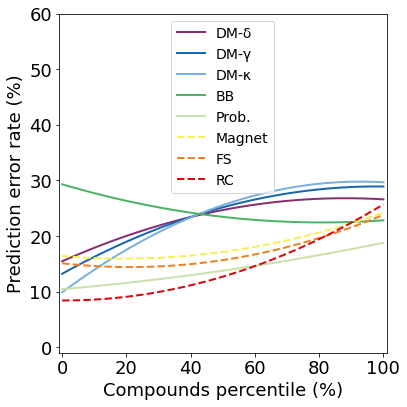

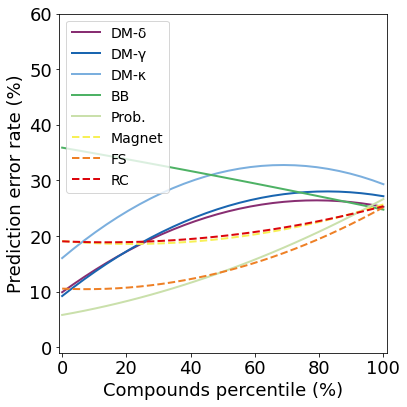

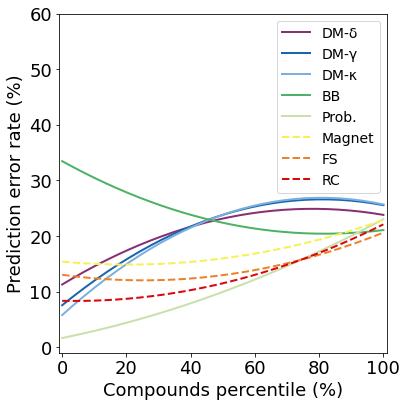

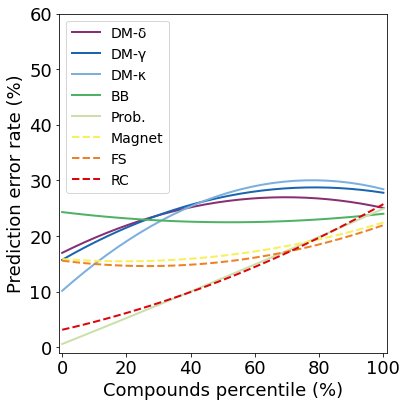

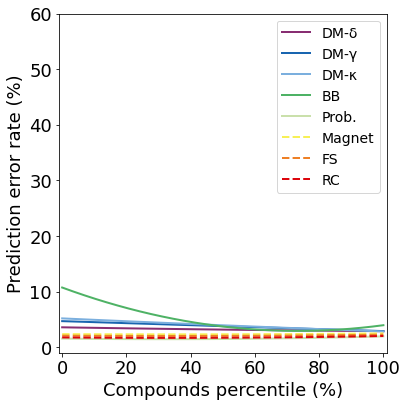

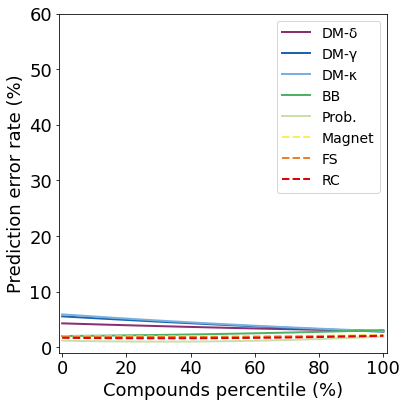

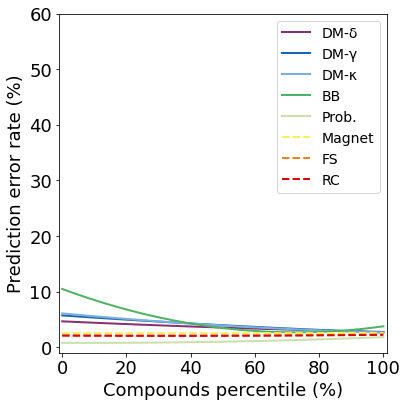

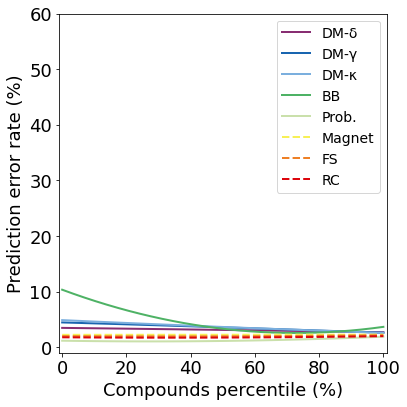

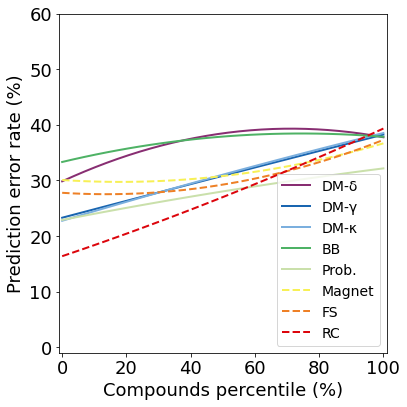

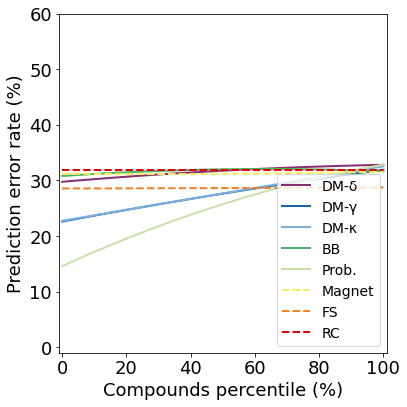

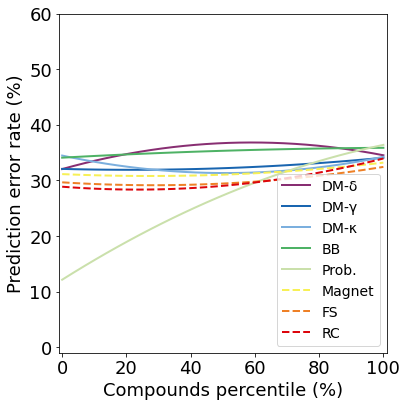

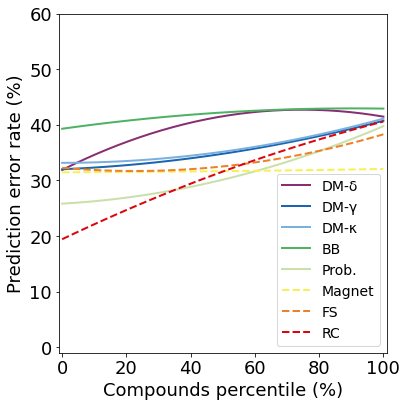

In [9]:
path_roc = Path(os.path.join(PATH_ROOT, 'plot_results', 'predictiveness_curve'))
for dataset in DATASETS:
    for clf, alias in zip(CLASSIFIERS, CLF_alias):
        plot_pc(clf, alias, dataset, path_roc / f'{dataset}_{alias}_pc.pdf')